In [10]:
import glob
import os
import numpy as np
from skimage import filters
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from GoogletNet import GoogLeNet
from SISE import SISE
from sklearn.linear_model import Ridge

In [11]:
def otsu_binary(img):
    thr = filters.threshold_otsu(img)
    binary = img > thr
    return np.multiply(binary, 255)

# 이미지 불러오기 및 전처리
def load_and_preprocess_images(img_paths, target_size=(224,224)):
    img_array_list = []
    for img_path in img_paths:
        img = np.array(Image.open(tf.io.gfile.GFile(img_path,'rb')).convert('RGB').resize(target_size, Image.BILINEAR), dtype=np.float32)
        img = img / 255.0
        img = np.expand_dims(img, axis=0)
        img_array_list.append(img)
    return np.vstack(img_array_list)

def create_cav_training_set(concepts, bottleneck, acts):
    x = []
    labels = []
    labels2text = {}
    min_data_points = np.min([acts[concept][bottleneck].shape[0] for concept in acts.keys()])

    for I, concept in enumerate(concepts):
        x.extend(acts[concept][bottleneck][:min_data_points].reshape(min_data_points, -1))
        labels.extend([I] * min_data_points)
        labels2text[I] = concept
    
    x = np.array(x)
    labels = np.array(labels)

    return x, labels, labels2text

def train_lm(lm, x, y, labels2text):
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.33, stratify=y)
    
    lm.fit(x_train, y_train)
    y_pred = lm.predict(x_test)
    
    num_classes = max(y) + 1
    acc = {}
    num_correct = 0
    for class_id in range(num_classes):
        # get indices of all test data that has this class.
        idx = (y_test == class_id)
        acc[labels2text[class_id]] = metrics.accuracy_score(
          y_pred[idx], y_test[idx])
        # overall correctness is weighted by the number of examples in this class.
        num_correct += (sum(idx) * acc[labels2text[class_id]])
    acc['overall'] = float(num_correct) / float(len(y_test))
    tf.compat.v1.logging.info('acc per class %s' % (str(acc)))
    return acc

# Step 0
- Model load

In [12]:
model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=True)

# Step 1

- SISE로 masked image 생성

In [13]:
sise = SISE(model, 'inceptionv3', 'test.jpg', 340, img_size=(299, 299))
sise.feature_extractor()
sise.feature_filtering()
sise.postprocess()

In [32]:
masked_imgs = {}
for k in sise.postprocessed_feature_maps.keys():
    masks = np.expand_dims(tf.transpose(sise.postprocessed_feature_maps[k], perm=[2,0,1]), axis=-1)
    masked_imgs[k] = sise.input_img*masks

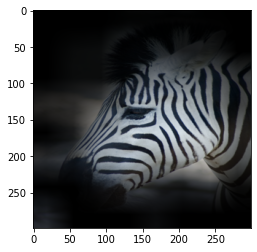

In [109]:
plt.imshow(masked_imgs['conv4'][0])

# Step 2
- TCAV method로 masked image들의 conceptual sensitivity 구하기

In [83]:
layer_names = ['mixed8', 'mixed9', 'mixed10']
target_class_names = ['zebra']
concept_names = ['striped']
random_concept_names = ['random1', 'random2', 'random3']
concept_pairs = []

for c in concept_names:
    for rc in random_concept_names:
        concept_pairs.append([c, rc])

layer_outputs = [model.get_layer(name).output for name in layer_names]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [84]:
input_imgs = {}
concepts = {}
randoms = {}

target_path = glob.glob('test_data/zebra/*')
concept_path = glob.glob('test_data/striped/*')
random_paths = [
    glob.glob('test_data/random1/*'),
    glob.glob('test_data/random2/*'),
    glob.glob('test_data/random3/*')
]

target_imgs = load_and_preprocess_images(target_path, target_size=(299,299))
concept_imgs = load_and_preprocess_images(concept_path, target_size=(299,299))
random_imgs = [load_and_preprocess_images(paths, target_size=(299,299)) for paths in random_paths]

concepts['zebra'] = target_imgs 
concepts['striped'] = concept_imgs
input_imgs['concepts'] = concepts

for i, random_img in enumerate(random_imgs):
    randoms[f'random{i+1}'] = random_img

input_imgs['randoms'] = randoms

In [87]:
input_imgs['concepts']['zebra'].shape

(37, 299, 299, 3)

In [88]:
for k in input_imgs.keys():
    for k2 in input_imgs[k].keys():
        activations = activation_model.predict(input_imgs[k][k2])
        for i, act in enumerate(activations):
            np.save(f'./acts_inceptionv3/{k2}_{layer_names[i]}', act, allow_pickle=False)

In [89]:
# 딕셔너리 초기화
acts = {}

# 파일 불러와서 딕셔너리에 저장
for file_path in glob.glob('./acts_inceptionv3/*'):
    # 파일 이름에서 concept와 layer 추출
    file_name = os.path.basename(file_path)
    parts = file_name.split('_')
    concept = parts[0]
    layer = parts[1].replace('.npy', '')
    
    # 데이터 불러오기
    data = np.load(file_path)
    
    # 딕셔너리에 저장
    if concept not in acts:
        acts[concept] = {}
    acts[concept][layer] = data

# 결과 확인
for concept, layers in acts.items():
    for layer, data in layers.items():
        print(f"Concept: {concept}, Layer: {layer}, Data shape: {data.shape}")

Concept: random1, Layer: mixed10, Data shape: (44, 8, 8, 2048)
Concept: random1, Layer: mixed8, Data shape: (44, 8, 8, 1280)
Concept: random1, Layer: mixed9, Data shape: (44, 8, 8, 2048)
Concept: random2, Layer: mixed10, Data shape: (42, 8, 8, 2048)
Concept: random2, Layer: mixed8, Data shape: (42, 8, 8, 1280)
Concept: random2, Layer: mixed9, Data shape: (42, 8, 8, 2048)
Concept: random3, Layer: mixed10, Data shape: (40, 8, 8, 2048)
Concept: random3, Layer: mixed8, Data shape: (40, 8, 8, 1280)
Concept: random3, Layer: mixed9, Data shape: (40, 8, 8, 2048)
Concept: striped, Layer: mixed10, Data shape: (50, 8, 8, 2048)
Concept: striped, Layer: mixed8, Data shape: (50, 8, 8, 1280)
Concept: striped, Layer: mixed9, Data shape: (50, 8, 8, 2048)
Concept: zebra, Layer: mixed10, Data shape: (37, 8, 8, 2048)
Concept: zebra, Layer: mixed8, Data shape: (37, 8, 8, 1280)
Concept: zebra, Layer: mixed9, Data shape: (37, 8, 8, 2048)


In [122]:
cavs = {}

for layer_name in layer_names:
    cavs[layer_name] = {}
    for concept_pair in concept_pairs:
        x, labels, labels2text = create_cav_training_set(concept_pair, layer_name, acts)
        lm = linear_model.SGDClassifier(alpha=0.1, max_iter=1000, tol=1e-3)
        acc = train_lm(lm, x, labels, labels2text)
        cav = [-1*lm.coef_[0], lm.coef_[0]]
        cavs[layer_name][concept_pair[0]]= cav

INFO:tensorflow:acc per class {'striped': 0.9230769230769231, 'random1': 1.0, 'overall': 0.96}
INFO:tensorflow:acc per class {'striped': 1.0, 'random2': 1.0, 'overall': 1.0}
INFO:tensorflow:acc per class {'striped': 1.0, 'random3': 1.0, 'overall': 1.0}
INFO:tensorflow:acc per class {'striped': 1.0, 'random1': 1.0, 'overall': 1.0}
INFO:tensorflow:acc per class {'striped': 1.0, 'random2': 1.0, 'overall': 1.0}
INFO:tensorflow:acc per class {'striped': 1.0, 'random3': 0.9230769230769231, 'overall': 0.96}
INFO:tensorflow:acc per class {'striped': 0.75, 'random1': 1.0, 'overall': 0.88}
INFO:tensorflow:acc per class {'striped': 0.8333333333333334, 'random2': 1.0, 'overall': 0.92}
INFO:tensorflow:acc per class {'striped': 0.9230769230769231, 'random3': 1.0, 'overall': 0.96}


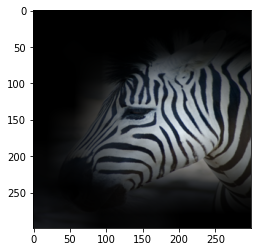

In [111]:
plt.imshow(masked_imgs['conv4'][20])

In [113]:
masked_imgs['conv4'][0].shape

(299, 299, 3)

In [133]:
layer_gradients = {}
cs = {}
batch_size = 32
num_batches = masked_imgs['conv4'].shape[0] // batch_size + (1 if masked_imgs['conv4'].shape[0] % batch_size != 0 else 0)

for layer_name in layer_names:
    img = tf.convert_to_tensor(input_imgs['concepts']['zebra'])

    for i in range(num_batches):
        with tf.GradientTape() as tape:
            tape.watch(img)
            logits_model = tf.keras.Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

            layer_act, logits = logits_model(masked_imgs['conv4'][i*batch_size:(i+1)*batch_size])
            selected_logit = logits[:, 340]

        gradient = tape.gradient(selected_logit, layer_act)

        if gradient is None:
            raise ValueError("Gradient computation returned None. Ensure the input tensor is correctly tracked.")
        layer_gradients[layer_name] = gradient


#         for layer_name in layer_names:
        cs[layer_name] = []
        for grad in layer_gradients[layer_name]:
            cs[layer_name].append(np.dot(np.reshape(grad,-1), cavs[layer_name]['striped'][0]))

In [134]:
cs

{'mixed8': [0.0011937864595563822,
  -0.006004496587960679,
  -0.0005475341620239224,
  -2.5297051843185315e-05,
  -0.00037800332506862135,
  -0.0027103546824542605,
  -0.0037975300496057795,
  0.05643013782178541,
  0.0023612420379630896,
  -0.0007486979067021409,
  0.00035525606228014185,
  0.0012330967704858957,
  0.0182111481010907,
  0.0019312632375387464,
  0.0005042501964581197,
  -0.0071209149831484965,
  0.08404407955407604,
  -0.0038679500775493443,
  -0.002541846649194376],
 'mixed9': [-0.0018723681618262023,
  -0.004617179607346971,
  -0.0010325534400248703,
  -0.00028267500864020685,
  -0.003968517220934995,
  -0.0016795190532223384,
  -0.0018252778638880114,
  0.02620813767318647,
  -0.00210652927768183,
  0.0011037992406476202,
  0.0003256628263609262,
  -0.0013449601878127728,
  0.023679585421728135,
  0.0026519457842182925,
  -0.0017587569494050973,
  -0.00304312123598905,
  0.03466229244994966,
  -0.0021723397445154004,
  -0.005235628328997828],
 'mixed10': [0.0124235

CS까지 구함

In [129]:
masked_imgs['conv4'].shape

(883, 299, 299, 3)

InceptionV3
- (9) activation_2 - 64
- (16) activation_4 - 192
- (86) mixed2 - 288
- (228) mixed7 - 768
- (310) mixed10 - 2048

레이어 선택 기준: 피쳐의 크기가 감소하기 전의 레이어 선택
- InceptionV3 모델의 경우는 피쳐맵 하나에서 여러개의 분기로 나눠져 따로 다운 샘플링 되기 때문에 크기가 감소하기 전 concat 레이어를 선택함